In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool, cpu_count
import importlib as imp
import gc; gc.enable()
import xgboost as xgb
import pandas as pd
pd.set_option('max_columns',1000)
import numpy as np
from sklearn import *
import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss as log_loss
import json
import mylibs.WSDN_FUNC as func
%cd e:\kaggle\wsdm
%matplotlib inline

D:\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


e:\kaggle\wsdm


D:\Miniconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Miniconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
def change_datatype(df):
    int_cols = list(df.select_dtypes(include=['int']).columns)
    for col in int_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

def change_datatype_float(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)

def plot_precision_recall_vs_threshold(train_y, scores):
    from sklearn.metrics import precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(train_y, scores)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recalls")
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 1, 0.03))
    plt.grid(True, linestyle='-.')
    plt.show()
    
def plot_roc_curve(train_y, scores):
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(train_y, scores)
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 0], [1, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [ ]:
# prepare base data
print("reading training and submission data...")
train = pd.read_csv("train.csv/train.csv")
test = pd.read_csv("sample_submission.csv/sample_submission.csv")

In [ ]:
print("processing transaction data...")
transactions = pd.read_csv('transactions.csv/transactions.csv')
date_cols = ['transaction_date', 'membership_expire_date']
for col in date_cols:
    transactions[col] = pd.to_datetime(transactions[col], format='%Y%m%d')
    
print("----processing transaction counts data...")
transaction_counts = transactions['msno'].value_counts().reset_index()
transaction_counts.columns = ['msno','trans_count']
train = pd.merge(train, transaction_counts, how='left', on='msno')
test = pd.merge(test, transaction_counts, how='left', on='msno')
transaction_counts=[]
gc.collect()

print("----processing transaction last record data...")
transaction_last_date = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transaction_last_date = transaction_last_date.drop_duplicates(subset=['msno'], keep='first')
transaction_last_date["discount"] = transaction_last_date['plan_list_price'] - transaction_last_date['actual_amount_paid']
transaction_last_date['is_discount'] = transaction_last_date.discount.apply(lambda x: 1 if x > 0 else 0)
transaction_last_date['amt_per_day'] = transaction_last_date['actual_amount_paid'] / transaction_last_date['payment_plan_days']
transaction_last_date['membership_duration'] = transaction_last_date.membership_expire_date - transaction_last_date.transaction_date
transaction_last_date['membership_duration'] = transaction_last_date['membership_duration'] / np.timedelta64(1, 'D')
transaction_last_date['membership_duration'] = transaction_last_date['membership_duration'].astype(int)
transaction_last_date = transaction_last_date.drop(list(transaction_last_date.select_dtypes(include=['datetime64[ns]']).columns), 1)
train = pd.merge(train, transaction_last_date, how='left', on='msno')
test = pd.merge(test, transaction_last_date, how='left', on='msno')
print('----retain transaction_last_date for members.')

print("----processing transaction last 2 months counts data...")
transaction_last2 = transactions.sort_values(by=['transaction_date'], ascending=[True]).reset_index(drop=True)
transaction_last2 = transaction_last2.set_index("transaction_date").truncate(before = '2017-02-01').reset_index()
transaction_last2 = pd.DataFrame(transaction_last2['msno'].value_counts().reset_index())
transaction_last2.columns = ['msno','trans_count2']
train = pd.merge(train, transaction_last2, how='left', on='msno')
test = pd.merge(test, transaction_last2, how='left', on='msno')
transaction_last2 = []
transactions = []
gc.collect()
print('transaction merged.')

In [ ]:
print("processing member data...")
members = pd.read_csv('members.csv/members.csv')
df_comb = pd.merge(transaction_last_date, members, on='msno', how='inner')
df_comb['autorenew_&_not_cancel'] = ((df_comb.is_auto_renew == 1) == (df_comb.is_cancel == 0)).astype(np.int8)
df_comb['notAutorenew_&_cancel'] = ((df_comb.is_auto_renew == 0) == (df_comb.is_cancel == 1)).astype(np.int8)
drop_cols = list(members.select_dtypes(include=['datetime64[ns]']).columns) + list(transaction_last_date.columns)
drop_cols.remove('msno')
df_comb = df_comb.drop(drop_cols, 1)
train = pd.merge(train, df_comb, how='left', on='msno')
test = pd.merge(test, df_comb, how='left', on='msno')
print("----data clean...")
gender = {'male':1, 'female':2}
train['gender'] = train['gender'].map(gender)
test['gender'] = test['gender'].map(gender)
train_bd_clipped = train["bd"].clip(18, 60)
test_bd_clipped = test["bd"].clip(18, 60)
train_bd_mean = train_bd_clipped.mean()
test_bd_mean = test_bd_clipped.mean()
train["bd"] = train["bd"].apply(lambda x: train_bd_mean if x <18 or x >60 else x )
test["bd"] = test["bd"].apply(lambda x: test_bd_mean if x <18 or x >60 else x )
train_bd_clipped = []
test_bd_clipped = []
transaction_last_date = []
members = []
df_comb = []
gc.collect()
print('members merged.')

In [ ]:
print("processing logs data...")
df_iter = pd.read_csv('user_logs.csv/user_logs.csv', low_memory=False, iterator=True, chunksize=10000000)
last_user_logs = []
i = 0 
for df in df_iter:
    if len(df)>0:
        print(df.shape)
        p = Pool(cpu_count())
        df = p.map(transform_df, np.array_split(df, cpu_count()))   
        df = pd.concat(df, axis=0, ignore_index=True).reset_index(drop=True)
        df = transform_df2(df)
        p.close(); p.join()
        last_user_logs.append(df)
        print('...', df.shape)
        df = []
        gc.collect()
    i+=1

last_user_logs = pd.concat(last_user_logs, axis=0, ignore_index=True).reset_index(drop=True)
last_user_logs = transform_df2(last_user_logs)

train = pd.merge(train, last_user_logs, how='left', on='msno')
test = pd.merge(test, last_user_logs, how='left', on='msno')
last_user_logs=[]
gc.collect()
print('logs merged.')

In [ ]:
del df_iter
user_logs = pd.read_csv('user_logs.csv/user_logs.csv', usecols=['msno'])
user_logs = pd.DataFrame(user_logs['msno'].value_counts().reset_index())
user_logs.columns = ['msno','logs_count']
train = pd.merge(train, user_logs, how='left', on='msno')
test = pd.merge(test, user_logs, how='left', on='msno')
user_logs = []
gc.collect()
print('user logs count merged.')

In [ ]:
# extra features
print("processing extra features...")
extra_features = pd.read_csv("extra_features.csv")
exclude_mean_cols = [col for col in extra_features.columns if not col.endswith("mean")]
extra_features = extra_features[exclude_mean_cols]
train = pd.merge(train, extra_features, how='left', on='msno')
test = pd.merge(test, extra_features, how='left', on='msno')
extra_features3 = pd.read_csv("extra_features3.csv")
train = pd.merge(train, extra_features3, how='left', on='msno')
test = pd.merge(test, extra_features3, how='left', on='msno')
extra_features4 = pd.read_csv("extra_features4.csv")
train = pd.merge(train, extra_features4, how='left', on='msno')
test = pd.merge(test, extra_features4, how='left', on='msno')
extra_features5 = pd.read_csv("extra_features5.csv")
train = pd.merge(train, extra_features5, how='left', on='msno')
test = pd.merge(test, extra_features5, how='left', on='msno')
del extra_features
del extra_features3
del extra_features4
del extra_features5
gc.collect()
print("extra features merged.")

In [ ]:
train.to_csv('train_features.csv', index=False)
test.to_csv('test_features.csv', index=False)

In [3]:
# training preparation
train = pd.read_csv("train_features.csv")
test = pd.read_csv("test_features.csv")
# missing values
data_pack = [train, test]
for i, data in enumerate(data_pack):
    data = data.replace([np.inf, -np.inf], np.nan)
    mean_cols = ['payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'discount', 'amt_per_day', 'membership_duration', 'bd'] 
    mode_cols = ['payment_method_id', 'is_auto_renew', 'is_cancel', 'is_discount', 'city', 'gender', 'registered_via', 'registration_init_time', 'autorenew_&_not_cancel', 'notAutorenew_&_cancel', 'date']
    other_cols = [col for col in data.columns if col not in mean_cols if col not in mode_cols]
    data[mean_cols] = data[mean_cols].fillna(data[mean_cols].mean())
    data[mode_cols] = data[mode_cols].fillna(data[mode_cols].mode().iloc[0])
    data[other_cols]= data[other_cols].fillna(0)
    data_pack[i] = data
train, test = data_pack
gc.collect()

84

In [4]:
change_datatype(train);change_datatype(test)
change_datatype_float(train);change_datatype_float(test)

In [5]:
# select training features
cols = [col for col in train.columns if col not in ['is_churn','msno']]
cols

['trans_count',
 'payment_method_id',
 'payment_plan_days',
 'plan_list_price',
 'actual_amount_paid',
 'is_auto_renew',
 'is_cancel',
 'discount',
 'is_discount',
 'amt_per_day',
 'membership_duration',
 'trans_count2',
 'city',
 'bd',
 'gender',
 'registered_via',
 'registration_init_time',
 'autorenew_&_not_cancel',
 'notAutorenew_&_cancel',
 'date',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'total_secs',
 'num_25_sum',
 'num_50_sum',
 'num_75_sum',
 'num_985_sum',
 'num_100_sum',
 'num_unq_sum',
 'total_secs_sum',
 'log_count',
 'logs_count',
 'num_25_sum_1m',
 'num_50_sum_1m',
 'num_75_sum_1m',
 'num_985_sum_1m',
 'num_100_sum_1m',
 'num_unq_sum_1m',
 'total_secs_sum_1m',
 'log_count_1m']

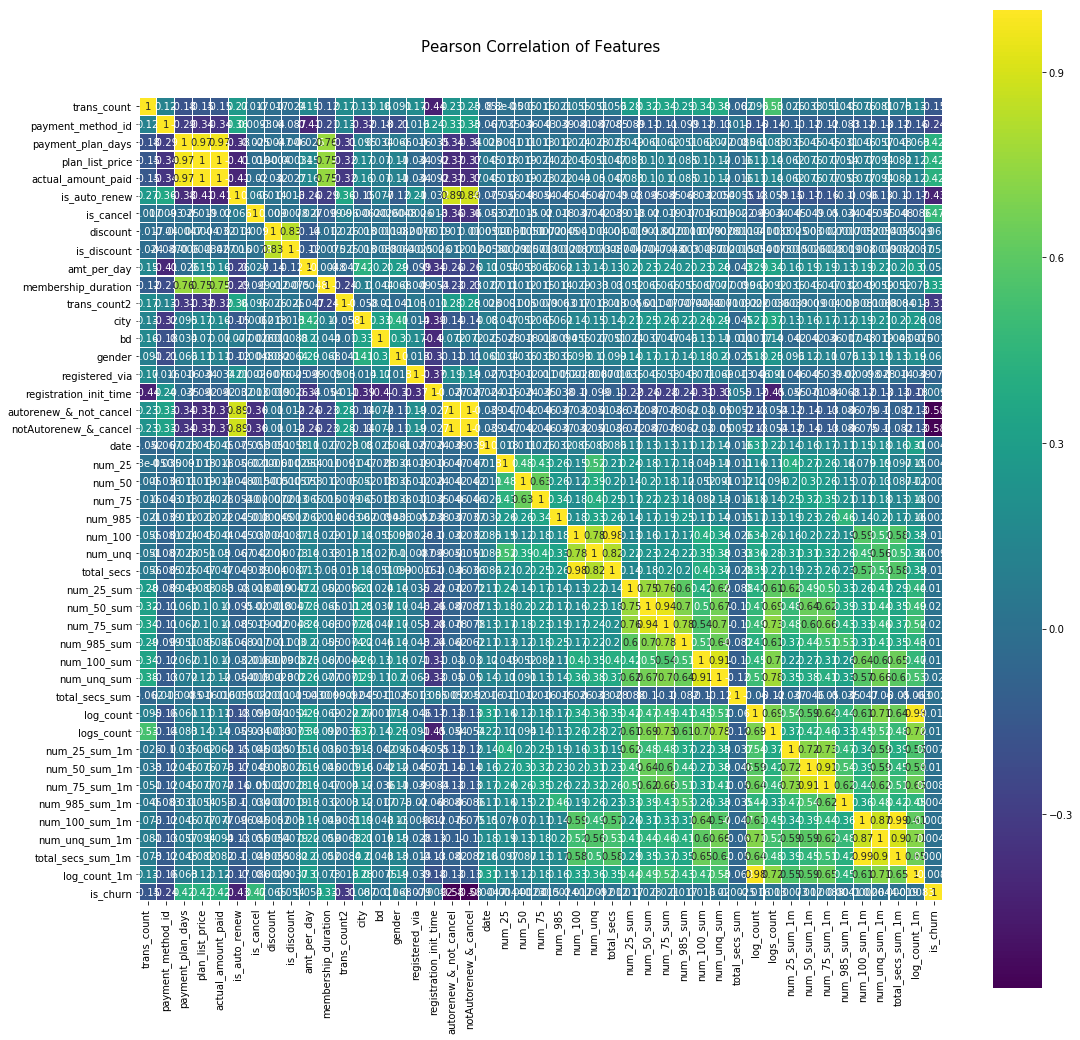

In [6]:
colormap = plt.cm.viridis
plt.figure(figsize=(18,18))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train[cols + ["is_churn"]].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [7]:
class ClfModel(object):
    feature_name_prefix = "%s_feature_%d"
    feature_index = 0

class XgbModel(ClfModel):    
    def __init__(self, params, kfold=None, ROUND=150, SEED=0):
        self.model = None
        self.new_feature_cols = []
        self.xgb_params = params
        self.kfold = kfold
        self.ROUND = ROUND
        self.SEED = SEED
    
    def train_pred(self, train_x, train_y, test_x, test_split_ratio = 0.3, valid_x = None, valid_y = None):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.new_feature_cols = []
        self.valid_x = valid_x
        self.valid_y = valid_y
        if self.kfold is not None:
            return self.__train_use_kfold(self.kfold)
        else:
            return self.__train_use_splitratio(test_split_ratio)
    
    def __train_use_kfold(self, kfold):
        training_prediction = np.zeros((self.train_x.shape[0],))
        test_prediction = np.empty((kfold.n_folds, self.test_x.shape[0]))
        for i, (train_index, test_index) in enumerate(kfold):
            print("xgb training round %d" % i)
            train_data_x = self.train_x[train_index]
            train_data_y = self.train_y[train_index]
            training_test_data_x = self.train_x[test_index]
            training_test_data_y = self.train_y[test_index]
            eval_list = [(xgb.DMatrix(train_data_x, train_data_y), 'train'), (xgb.DMatrix(training_test_data_x, training_test_data_y), 'validation')]
            model = xgb.train(self.xgb_params, xgb.DMatrix(train_data_x, train_data_y), self.ROUND, evals=eval_list, maximize=False, verbose_eval=50, early_stopping_rounds=50)
            training_prediction[test_index] = model.predict(xgb.DMatrix(training_test_data_x), ntree_limit=model.best_ntree_limit)
            test_prediction[i, :] = model.predict(xgb.DMatrix(self.test_x), ntree_limit=model.best_ntree_limit)
            del model
            gc.collect()
        new_feature = ClfModel.feature_name_prefix % ("xgb", ClfModel.feature_index)
        ClfModel.feature_index += 1
        training_prediction = pd.DataFrame(training_prediction.clip(0.0000001, 0.999999), columns=[new_feature])
        test_prediction = pd.DataFrame(test_prediction.clip(0.0000001, 0.999999).mean(axis=0).reshape(-1, 1), columns=[new_feature])
        self.new_feature_cols += [new_feature]
        print(self.new_feature_cols)
        return training_prediction, test_prediction, self.new_feature_cols, [1]
    
    def __train_use_splitratio(self, ratio):
        print("stacking training.")
        if ratio > 0:
            train_x, valid_x, train_y, valid_y = model_selection.train_test_split(self.train_x, self.train_y, test_size=ratio, random_state=self.SEED)
            eval_list = [(xgb.DMatrix(train_x, train_y), 'train'), (xgb.DMatrix(valid_x, valid_y), 'validation')]
        else:
            train_x = self.train_x
            train_y = self.train_y
            if self.valid_x is None or self.valid_y is None:
                valid_x = self.train_x
                valid_y = self.train_y
            else:
                valid_x = self.valid_x
                valid_y = self.valid_y
            eval_list = [(xgb.DMatrix(train_x, train_y), 'train')]
        final_xgb_model = xgb.train(xgb_params, xgb.DMatrix(train_x, train_y), self.ROUND, evals=eval_list, maximize=False, verbose_eval=50, early_stopping_rounds=50)
        valid_preds = final_xgb_model.predict(xgb.DMatrix(valid_x), ntree_limit=final_xgb_model.best_ntree_limit).clip(0.0000001, 0.999999)
        test_preds = final_xgb_model.predict(xgb.DMatrix(self.test_x), ntree_limit=final_xgb_model.best_ntree_limit).clip(0.0000001, 0.999999)
        self.model = final_xgb_model
        return valid_preds, test_preds, valid_y

In [8]:
class SklearnModel(ClfModel):
    def __init__(self, clf, params, kfold, clfname='sklearn', SEED=0, predict_method='proba', parallel=False, parallel_kernel=None):
        params['random_state'] = SEED
        self.parallel = parallel
        self.parallel_kernel = parallel_kernel
        if not self.parallel or not self.parallel_kernel:
            self.clf = clf(**params)
            self.use_parallel = False
        else:
            self.clf = [clf(**params) for i in range(kfold.n_folds)]
            self.use_parallel = True
        self.new_feature_cols = []
        self.kfold = kfold
        self.SEED = SEED
        self.clfname = clfname
        self.predict_method = predict_method
        
    def train_pred(self, train_x, train_y, test_x, test_split_ratio = 0.3, valid_x = None, valid_y = None):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.n_classes_ = len(set(train_y))
        self.new_feature_cols = []
        self.valid_x = valid_x
        self.valid_y = valid_y
        if self.kfold is not None:
            return self.__train_use_kfold(self.kfold)
        else:
            return self.__train_use_splitratio(test_split_ratio)
        
    def __train_use_kfold(self, kfold):
        feature_cols = 1
        if self.predict_method == "proba" or self.predict_method == "log_proba":
            feature_cols = self.n_classes_
        training_prediction = np.zeros((self.train_x.shape[0], feature_cols))
        test_prediction = np.empty((kfold.n_folds, self.test_x.shape[0], feature_cols))
        for i, (train_index, test_index) in enumerate(kfold):
            print(self.clfname + (" training round %d" % i))
            train_data_x = self.train_x[train_index]
            train_data_y = self.train_y[train_index]
            training_test_data_x = self.train_x[test_index]
            training_test_data_y = self.train_y[test_index]
            if not self.use_parallel:
                self.clf.fit(train_data_x, train_data_y)
                if self.predict_method == "proba":
                    training_prediction[test_index] = self.clf.predict_proba(training_test_data_x)
                    test_prediction[i, :] = self.clf.predict_proba(self.test_x)
                elif self.predict_method == "log_proba":
                    training_prediction[test_index] = self.clf.predict_log_proba(training_test_data_x)
                    test_prediction[i, :] = self.clf.predict_log_proba(self.test_x)
                else:
                    training_prediction[test_index] = self.clf.predict(training_test_data_x).reshape(-1, 1)
                    test_prediction[i, :] = self.clf.predict(self.test_x).reshape(-1, 1)
            else:
                inner_item = {"clf": self.clf[i], "predict_method": self.predict_method, "round_i": i, "test_index": test_index,
                              "train_data_x": train_data_x, "train_data_y": train_data_y, "test_x": self.test_x,
                              "training_test_data_x": training_test_data_x, "training_test_data_y": training_test_data_y
                             }
                if i == 0:
                    parallel_data = [inner_item]
                else:
                    parallel_data.append(inner_item)
        classes = []
        if self.use_parallel:
            self.pool = Pool(cpu_count())
            predsResult = self.pool.map(self.parallel_kernel, parallel_data)
            for predsItem in predsResult:
                training_prediction_item, test_prediction_item, round_i, test_index_item, classes_ = predsItem
                training_prediction[test_index_item] = training_prediction_item
                test_prediction[round_i, :] = test_prediction_item
                classes.append(classes_)
            self.pool.close()
            self.pool.join()
            if self.predict_method == "proba" or self.predict_method == "log_proba":
                classes_max_len = -1
                tmp_classes = None
                # get real classes_, which has the maximum length
                for class_ in classes:
                    if len(class_) > classes_max_len:
                        classes_max_len = len(class_)
                        tmp_classes = class_
                classes = tmp_classes
            else:
                classes = [1]
        training_prediction = training_prediction.clip(0.0000001, 0.999999)
        test_prediction = test_prediction.clip(0.0000001, 0.999999)
        training_prediction_dataframe = None
        test_prediction_dataframe = None
        for i in range(feature_cols):
            new_feature = ClfModel.feature_name_prefix % (self.clfname, ClfModel.feature_index)
            ClfModel.feature_index += 1
            self.new_feature_cols += [new_feature]
            cur_train_df = pd.DataFrame(training_prediction[:, i], columns=[new_feature])
            cur_test_df = pd.DataFrame(test_prediction[:, :, i].mean(axis=0).reshape(-1, 1), columns=[new_feature])
            if i != 0:
                training_prediction_dataframe = pd.concat([training_prediction_dataframe, cur_train_df], axis=1)
                test_prediction_dataframe = pd.concat([test_prediction_dataframe, cur_test_df], axis=1)
            else:
                training_prediction_dataframe = cur_train_df
                test_prediction_dataframe = cur_test_df
        print(self.new_feature_cols)
        del self.train_x
        del self.train_y
        del self.test_x
        del training_prediction
        del test_prediction
        gc.collect()
        return training_prediction_dataframe, test_prediction_dataframe, self.new_feature_cols, list(set(classes))
        
    def __train_use_splitratio(self, ratio):
        print("stacking training.")
        if ratio > 0:
            train_x, valid_x, train_y, valid_y = model_selection.train_test_split(self.train_x, self.train_y, test_size=ratio, random_state=self.SEED)
        else:
            train_x = self.train_x
            train_y = self.train_y
            if self.valid_x is None or self.valid_y is None:
                valid_x = self.train_x
                valid_y = self.train_y
            else:
                valid_x = self.valid_x
                valid_y = self.valid_y
        self.clf.fit(train_x, train_y)
        valid_preds = self.clf.predict(valid_x).clip(0.0000001, 0.999999)
        test_preds = self.clf.predict(self.test_x).clip(0.0000001, 0.999999)
        del self.train_x
        del self.train_y
        del self.test_x
        gc.collect()
        return valid_preds, test_preds, valid_y

In [9]:
class ClfFeaturePipline(object):
    def __init__(self, train, test, train_data_x, train_data_y, test_data, clf_ins_list):
        self.final_train_data = train
        self.final_test_data = test
        self.train_data_x = train_data_x
        self.train_data_y  = train_data_y
        self.test_data = test_data
        self.clf_ins_list = clf_ins_list
        self.feature_cols = []
        self.n_classes_feature_cols_map = {}
    
    def train_pred(self):
        self.feature_cols = []
        for clf in self.clf_ins_list:
            training_predctions, test_predictions, new_feature_cols, classes = clf.train_pred(self.train_data_x, self.train_data_y, self.test_data)
            self.final_train_data = pd.concat([self.final_train_data, training_predctions], axis=1)
            self.final_test_data = pd.concat([self.final_test_data, test_predictions], axis=1)
            self.feature_cols = self.feature_cols + new_feature_cols
            for i, class_name in enumerate(classes):
                class_name = str(class_name)
                if class_name not in self.n_classes_feature_cols_map:
                    self.n_classes_feature_cols_map[class_name] = []
                self.n_classes_feature_cols_map[class_name].append(new_feature_cols[i])
            del training_predctions
            del test_predictions
        gc.collect()
        return self.final_train_data, self.final_test_data, self.feature_cols, self.n_classes_feature_cols_map

In [10]:
# xgb features
xgb_params = {
    'eta': 0.02, #use 0.002
    'max_depth': 7,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': i,
    'silent': True,       
    'tree_method': 'gpu_hist',
}

# random forest features
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': False, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'probability': True,
    'C' : 0.025
}

In [ ]:
NFOLDS = 5
SEED = 0
ROUND = 200
forest_layers = 2 # round need to train
cur_index = 6 # change depend on training process
train_data = train#train.sample(80000, random_state=SEED).reset_index(drop=True)
test_data = test#train.sample(80000, random_state=SEED+5).reset_index(drop=True)#test.sample(80000, random_state=SEED).reset_index(drop=True)
scaler = StandardScaler()
kf = KFold(train_data.shape[0], n_folds= NFOLDS, random_state=SEED)

ClfModel.feature_index = 42 # feature index start pos
xgb_model = XgbModel(xgb_params, kf, ROUND=ROUND)
rf_model = SklearnModel(RandomForestClassifier, rf_params, kf, "rf", SEED, parallel=True, parallel_kernel=func.sklearn_kernel)
et_model = SklearnModel(ExtraTreesClassifier, et_params, kf, "et", SEED, parallel=True, parallel_kernel=func.sklearn_kernel)
ada_model = SklearnModel(AdaBoostClassifier, ada_params, kf, "ada", SEED, parallel=True, parallel_kernel=func.sklearn_kernel)
gp_model = SklearnModel(GradientBoostingClassifier, gb_params, kf, "gp", SEED, parallel=True, parallel_kernel=func.sklearn_kernel)
svc_model = SklearnModel(SVC, svc_params, kf, "svc", SEED)

# final_train_data = train_data # if training first time
# final_test_data = test_data # if training first time
train_data_y = train_data["is_churn"].values

new_feature_cols = cols
for i in range(forest_layers):
    cur_index += i
    print("----------forest layer %d" % cur_index)
    %time final_train_data_x = scaler.fit_transform(final_train_data[new_feature_cols].values)
    %time final_test_data_x = scaler.fit_transform(final_test_data[new_feature_cols].values)
    %time final_train_data, final_test_data, added_feature_cols, classes_features_map = ClfFeaturePipline(final_train_data, final_test_data, final_train_data_x, train_data_y, final_test_data_x, [xgb_model, rf_model, et_model, gp_model]).train_pred()
    print("-----%d--classes_features_map---" % cur_index, classes_features_map)
    final_train_data.to_csv('final_train_data_layer%d.csv' % cur_index, index=False)
    final_test_data.to_csv('final_test_data_layer%d.csv' % cur_index, index=False)
    json.dump(classes_features_map, open('classes_features_map_layer-%d.txt' % cur_index, 'w'), ensure_ascii=False)
    new_feature_cols = new_feature_cols + added_feature_cols

----------forest layer 6
Wall time: 3.17 s
Wall time: 2.96 s
xgb training round 0
[0]	train-logloss:0.673839	validation-logloss:0.676194
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.209853	validation-logloss:0.254331
[100]	train-logloss:0.0841	validation-logloss:0.161583
[150]	train-logloss:0.041907	validation-logloss:0.133252
[199]	train-logloss:0.027137	validation-logloss:0.126711
xgb training round 1
[0]	train-logloss:0.674367	validation-logloss:0.673496
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.223509	validation-logloss:0.200461
[100]	train-logloss:0.102222	validation-logloss:0.071223
[150]	train-logloss:0.062032	validation-logloss:0.027565
[199]	train-logloss:0.047934	validation-logloss:0.012038
xgb training 

In [11]:
# i = 5
# final_train_data = pd.read_csv('final_train_data_layer%d.csv' % i)
# final_test_data = pd.read_csv('final_test_data_layer%d.csv' % i)
# new_feature_cols = cols
# for j in range(i + 1):
#     classes_features_map = json.load(open('classes_features_map_layer-%d.txt' % j))
#     added_feature_cols = classes_features_map['0'] + classes_features_map['1']
#     new_feature_cols += added_feature_cols 

In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(18,18))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(final_train_data[new_feature_cols + ["is_churn"]].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [12]:
new_feature_cols

['trans_count',
 'payment_method_id',
 'payment_plan_days',
 'plan_list_price',
 'actual_amount_paid',
 'is_auto_renew',
 'is_cancel',
 'discount',
 'is_discount',
 'amt_per_day',
 'membership_duration',
 'trans_count2',
 'city',
 'bd',
 'gender',
 'registered_via',
 'registration_init_time',
 'autorenew_&_not_cancel',
 'notAutorenew_&_cancel',
 'date',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'total_secs',
 'num_25_sum',
 'num_50_sum',
 'num_75_sum',
 'num_985_sum',
 'num_100_sum',
 'num_unq_sum',
 'total_secs_sum',
 'log_count',
 'logs_count',
 'num_25_sum_1m',
 'num_50_sum_1m',
 'num_75_sum_1m',
 'num_985_sum_1m',
 'num_100_sum_1m',
 'num_unq_sum_1m',
 'total_secs_sum_1m',
 'log_count_1m',
 'rf_feature_1',
 'et_feature_3',
 'gp_feature_5',
 'xgb_feature_0',
 'rf_feature_2',
 'et_feature_4',
 'gp_feature_6',
 'rf_feature_8',
 'et_feature_10',
 'gp_feature_12',
 'xgb_feature_7',
 'rf_feature_9',
 'et_feature_11',
 'gp_feature_13',
 'rf_feature_15',
 'et_fe

In [ ]:
final_xgb_model = XgbModel(xgb_params, ROUND=ROUND)
validation_preds, final_preds, validation_y = final_xgb_model.train_pred(final_train_data[new_feature_cols], final_train_data['is_churn'], final_test_data[new_feature_cols], -1)
# validation_preds, final_preds, validation_y = final_xgb_model.train_pred(final_train_data[new_feature_cols], final_train_data['is_churn'], final_test_data[new_feature_cols], -1, final_test_data[new_feature_cols], final_test_data['is_churn'])
test['is_churn'] = final_preds
test[['msno','is_churn']].to_csv('submission.csv.gz', index=False, compression='gzip')
del final_preds
gc.collect()

In [ ]:
# another preds
# final_test_data['is_churn'] = final_test_data[classes_features_map[1]].mean(axis=1)
# final_test_data[['msno','is_churn']].to_csv('submission-mean.csv.gz', index=False, compression='gzip')
# validation_preds = final_train_data[classes_features_map[1]].mean(axis=1)
# validation_y = train_data_y

In [ ]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=final_xgb_model.model)
plt.show()
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plot_precision_recall_vs_threshold(validation_y, validation_preds)
plt.rcParams['figure.figsize'] = (7.0, 7.0)
plot_roc_curve(validation_y, validation_preds)
gc.collect()

In [ ]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plot_precision_recall_vs_threshold(final_train_data['is_churn'], final_train_data['xgb_feature_0'])

In [ ]:
print(validation_preds[:10])
print(validation_y[:10])
print((np.round(validation_preds) == validation_y).astype(np.int16).sum() / len(validation_y))
print(log_loss(final_train_data['is_churn'], validation_preds))
#print((np.round(final_train_data[[col for col in final_train_data.columns if "feature" in col]].mean(axis=1)) == final_train_data['is_churn']).astype(np.int16).sum() / len(final_train_data))
#print((np.round(final_test_data[added_feature_cols].mean(axis=1)) == final_test_data['is_churn']).astype(np.int16).sum() / len(final_test_data))
#print(log_loss(final_test_data['is_churn'], np.round(final_test_data[added_feature_cols].mean(axis=1))))
final_train_data.head(10)

In [ ]:
final_train_data.iloc[np.where(np.round(final_train_data[[col for col in final_train_data.columns if "feature" in col]].mean(axis=1)) != final_train_data['is_churn'])].head(5)

In [ ]:
del validation_y
del validation_preds

In [ ]:
del final_train_data
del final_test_data
del final_xgb_model
gc.collect()